# Cochella vs Normal Tour Analysis 

Exploring the setlists of 4 artists' Coachella Setlist and shows in the year prior or after the Coachella weekends. 

## Analysis Setup

### Imports and Configurations

In [ ]:
# Standard imports to run concert_analytics

import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), "../../"))
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd

from postgres import fetch_table,run_query

import logging

logging.basicConfig(level=logging.INFO)  # DEBUG < INFO < WARNING < ERROR < CRITICAL

pd.set_option("display.max_columns", None)  # Show all columns


### Gather Data into CSV and dataframe

In [34]:
# fetch setlist and spotify metadata

query="""
select 
	*
from 
	analytics_project.project_002_coachella_master_setlist_data
"""

df = run_query(query)
df['track_song_name'] = df['track_song_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)
df.to_csv('coachella_vs_normal_tool_master_setlist_data.csv',index=False)
df.head()

,artist_name_hint,event_set_song_id,event_id,event_date,event_info,event_url,event_tour_id,event_tour,venue_id,venue_name,venue_city,venue_state_code,venue_country_code,venue_latitude,venue_longitude,set_index,set_index_reversed,encore_index,encore_flag,song_index,song_index_reversed,song_position_in_set_index,song_position_in_set_index_reversed,song_name,song_info,song_cover_flag,song_cover_artist_mbid,song_cover_artist_name,song_with_flag,song_with_artist_mbid,song_with_artist_name,song_last_event_set_song_id,song_last_event_id,song_last_event_date,is_coachella,coachella_weekend,days_before_first_coachella_date,days_after_last_coachella_date,album_id,album_url,album_uri,album_type,album_name,album_total_tracks,album_release_date,album_image_url,album_popularity,track_id,track_url,track_uri,track_disk_number,track_duration_seconds,track_name,track_number,track_popularity,track_irsc,event_total_songs,event_total_sets,event_total_encore_songs,event_total_non_encore_songs,track_song_name
0,Turnstile,0002b3c2920a7a892b5eb923c2be0cc7,bb2917e,2022-07-17,None,https://www.setlist.fm/setlist/turnstile/2022/...,8b6d54e538f4a76258d7e59705075ac5,The Turnstile Love Connection Tour,9df3c61ef0de246d0d65076fff54c276,Hippodrome de Longchamp,Paris,11,FR,48.853000,2.349000,1,1,0,False,17,2,17,2,HOLIDAY,None,False,None,None,False,None,None,95fb27888140129d65dd33cca16c5267,23b2f813,2022-07-18,False,None,NaN,83.0,2NrYPcMmQBlbBxopc2XlzS,https://api.spotify.com/v1/albums/2NrYPcMmQBlb...,spotify:album:2NrYPcMmQBlbBxopc2XlzS,album,GLOW ON,15.0,2021-08-27,https://i.scdn.co/image/ab67616d0000b273a4499c...,70.0,1dB0NylVkpjdOe8DiekIs7,https://api.spotify.com/v1/tracks/1dB0NylVkpjd...,spotify:track:1dB0NylVkpjdOe8DiekIs7,1.0,172.0,HOLIDAY,5.0,66.0,NLA322100053,18,1,0,18,HOLIDAY
1,BillieEilish,00099633e8cf805879ce7c019f3327a2,bb1ad0a,2022-09-26,None,https://www.setlist.fm/setlist/billie-eilish/2...,f5c70423c1e8640af77041cb8d1217ec,Happier Than Ever: The World Tour,7e38a6c0215ed5a7bfe6ed06ad6dbd0a,Rod Laver Arena,Melbourne,VIC,AU,-37.813997,144.963323,1,4,0,False,5,18,5,7,my strange addiction,None,False,None,None,False,None,None,f13f017985f214560d8519180916fd20,43b19b37,2022-09-29,False,None,NaN,154.0,0S0KGZnfBGSIssfF54WSJh,https://api.spotify.com/v1/albums/0S0KGZnfBGSI...,spotify:album:0S0KGZnfBGSIssfF54WSJh,album,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",14.0,2019-03-29,https://i.scdn.co/image/ab67616d0000b27350a314...,88.0,3Tc57t9l2O8FwQZtQOvPXK,https://api.spotify.com/v1/tracks/3Tc57t9l2O8F...,spotify:track:3Tc57t9l2O8FwQZtQOvPXK,1.0,179.0,my strange addiction,9.0,78.0,USUM71900769,22,4,0,22,my strange addiction
2,Turnstile,000a22e3fdc7b20060c6406825cc5456,5bbec328,2022-11-03,None,https://www.setlist.fm/setlist/turnstile/2022/...,8b6d54e538f4a76258d7e59705075ac5,The Turnstile Love Connection Tour,ba63d9d2a43b3084aa8e4a412c794be1,Hollywood Palladium,Los Angeles,CA,US,34.052000,-118.244000,1,1,0,False,11,8,11,8,FLY AGAIN,None,False,None,None,False,None,None,5e3fb90c469b1808dd14efac5b8712cf,4bbecf82,2022-11-04,False,None,NaN,192.0,2NrYPcMmQBlbBxopc2XlzS,https://api.spotify.com/v1/albums/2NrYPcMmQBlb...,spotify:album:2NrYPcMmQBlbBxopc2XlzS,album,GLOW ON,15.0,2021-08-27,https://i.scdn.co/image/ab67616d0000b273a4499c...,70.0,53mkoU4zonxWTbgcNOYy1b,https://api.spotify.com/v1/tracks/53mkoU4zonxW...,spotify:track:53mkoU4zonxWTbgcNOYy1b,1.0,151.0,FLY AGAIN,8.0,59.0,NLA322100056,18,1,0,18,FLY AGAIN
3,BillieEilish,000cd01c9ddfa1de5f8f2cc34c2039c1,63b42233,2022-06-12,None,https://www.setlist.fm/setlist/billie-eilish/2...,f5c70423c1e8640af77041cb8d1217ec,Happier Than Ever: The World Tour,0d8a3b979d5d2dd3ebe3f23fb41be142,The O2 Arena,London,ENG,GB,51.508415,-0.125533,1,4,0,False,7,17,7,5,you should see me in a crown,None,False,None,None,False,None,None,dac1de3223545127624e0b8dde585681,43b40b23,2022-06-14,False,None,NaN,48.0,0S0KGZnfBGSIssfF54WSJh,https://api.spotify.com/v1/albums/0S0KGZnfBGSI...,spotify:album:0S0KGZnfBGSIssfF54WSJh,album,"WHEN WE ALL FALL ASLEEP, WHER

### Plotting Imports

In [31]:
from plotnine import ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime, element_blank,element_line

#Colors
gaffer_colors = {
    "lightAmpOrange": "#FB9E50"
    , "floodPink": "#F986BA"
    , "setlistBlue": "#3C7DC4"
    , "spotRed": "#D64848"
    , "ampOrange": "#F25C05"
    , "lightBlue: Appendix":"#A7ECF5"
    , "encorePurple": "#5D4E8C"
    , "stageGreen": "#33C27D"
    , "clockYellow": "#F6D357"
    , "spotlightCream": "#FAF3E0"
    , "gafferGrey": "#777777"
    , "backstageBlack":"#1C1C1C"
}

def gaffer_theme(fig_width=9,fig_height=16):
    #Basic Fonts
    base_family_axis="Courier New"
    base_family_title="Helvetica"

    return theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(fig_width,fig_height)
        
        # Backgrounds
        , plot_background=element_rect(fill=gaffer_colors["spotlightCream"], color=None)
        , panel_background=element_rect(fill=gaffer_colors["spotlightCream"], color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color=gaffer_colors["gafferGrey"]
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color=gaffer_colors["gafferGrey"]
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color=gaffer_colors["gafferGrey"]
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color=gaffer_colors["spotlightCream"]
        )
        ,panel_grid_major_x = element_line(
            color=gaffer_colors["gafferGrey"]
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )

## Analysis

### Song Frequency vs. Coachella Feature

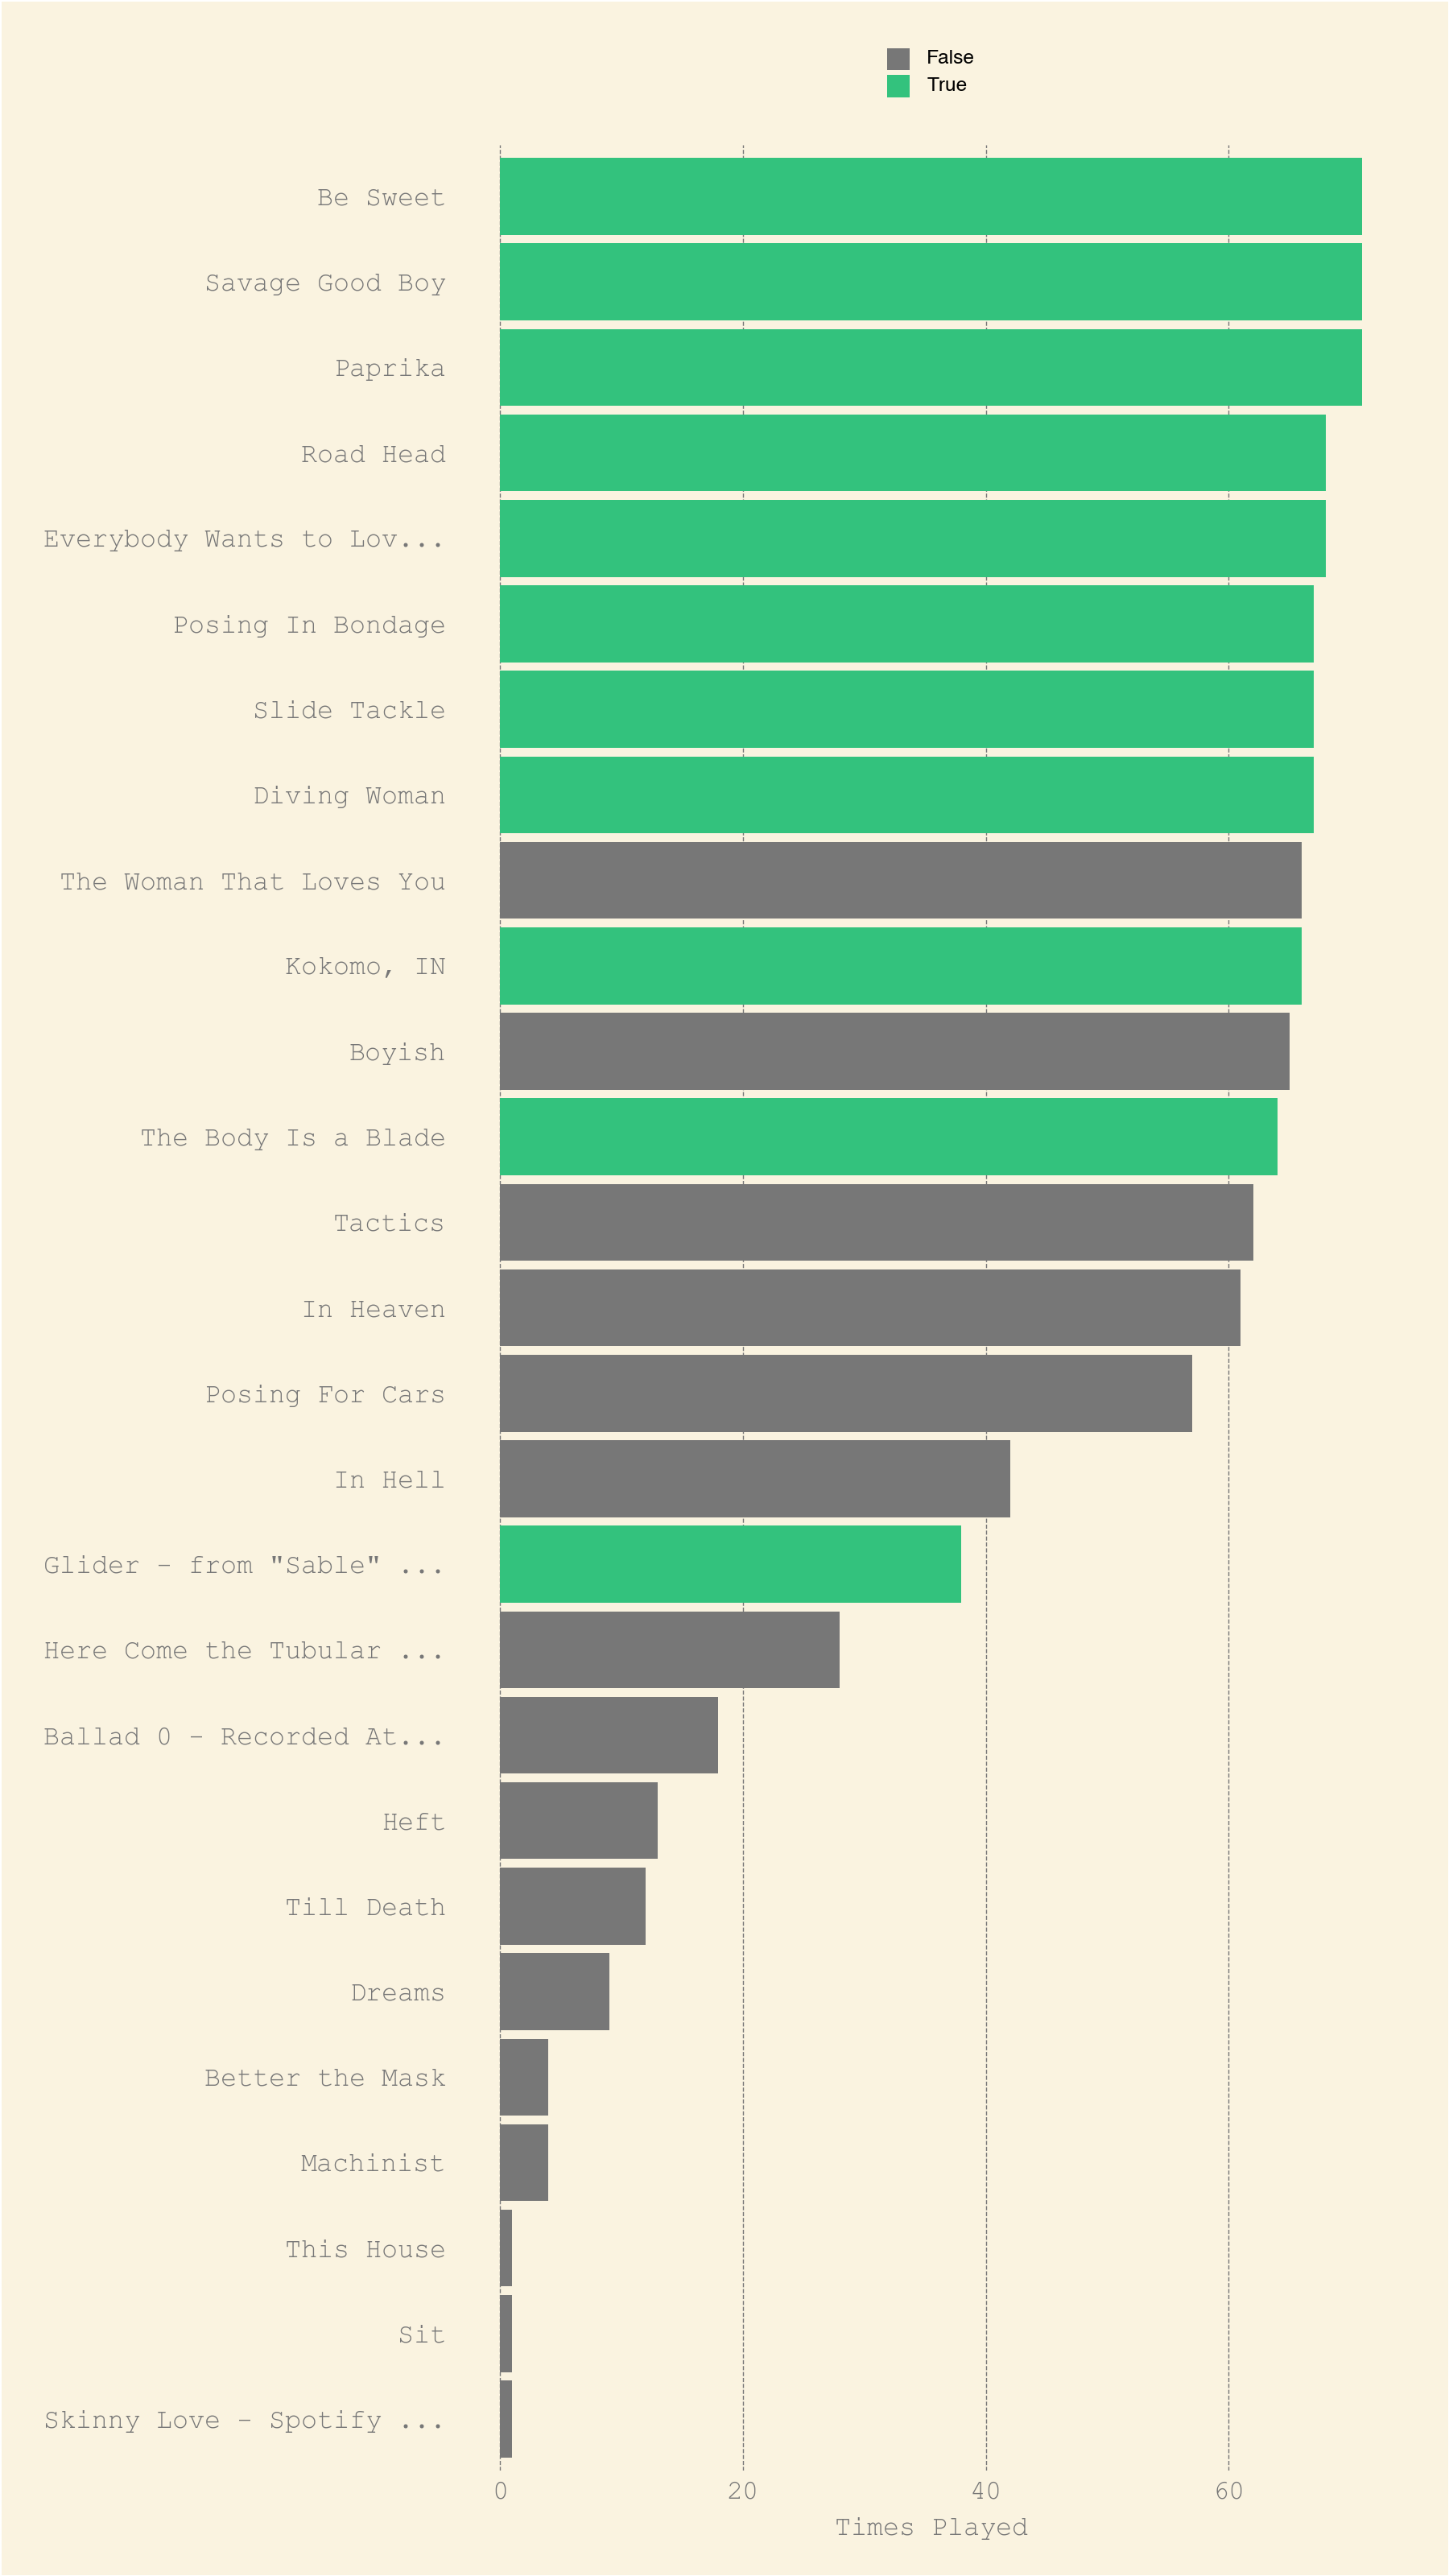

In [35]:
coachella_and_prior_df = df[
    (df["days_before_first_coachella_date"].notna()) |
    (df["is_coachella"] == True)
]

# Count how often each song was played
artist_song_counts_df = (
    coachella_and_prior_df.groupby(["artist_name_hint","track_song_name"])
    .agg(
        frequency=("song_name", "count"),
        played_at_coachella=("is_coachella", "any")  # Boolean: True if ever played at Coachella
    )
    .reset_index()
)

artist_song_counts_df = (
    artist_song_counts_df[
    artist_song_counts_df["artist_name_hint"] == "JapaneseBreakfast"
    ]
    .sort_values('frequency', ascending=False)
    .reset_index(drop=True)
)

artist_song_counts_df.head()

from plotnine import ggplot, aes, geom_bar, coord_flip, labs, scale_fill_manual 

# Create the base plot
plot = (
    ggplot(artist_song_counts_df)
    + aes(x="reorder(track_song_name, frequency)", y="frequency", fill="played_at_coachella")
    + geom_bar(stat="identity")
    + coord_flip()  # Makes it horizontal
    + scale_fill_manual(
        values={
            True: gaffer_colors["stageGreen"],   # Color for songs played at Coachella
            False: gaffer_colors["gafferGrey"]  # Color for songs not played at Coachella
        }
    )
    + labs(
        x="Song",
        y="Times Played",
        fill="Played at Coachella?",
        title="Song Frequencies Prior to and at Coachella"
    )
    + gaffer_theme()
)

plot


# plot.save(
#     filename="viz/0002-mewithoutYou-Opener_Frequency.svg",
#     format="svg",
#     width=12,      # inches
#     height=9,     # adjust to your chart’s shape
#     dpi=300        # high-quality output
# )